In [1]:
#import pytorch and setting up device agnostic code
import torch
from torch import nn
print(torch.__version__)

2.0.1+cu118


In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
#Get the data

In [4]:
import requests
import zipfile
from pathlib import Path

#Setup path to data folder
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists.... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

#Download pizza,steak,sushi data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza,steak,sushi data...")
    f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza,steak,sushi data...")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza,steak,sushi data...


In [5]:
#2.Becoming one with the data(data preparation and data exploration)
import os
def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [7]:
#Setting up training and testing paths
train_dir=image_path/"train"
test_dir=image_path/"test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

data/pizza_steak_sushi/train/steak/1839481.jpg
steak
Random image path: data/pizza_steak_sushi/train/steak/1839481.jpg
Image class: steak
Image height: 512
Image width: 512


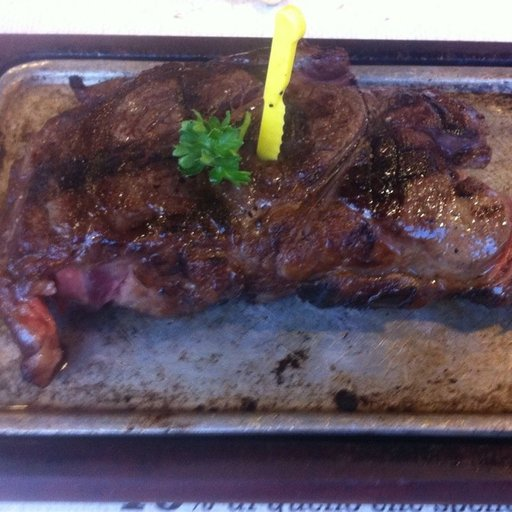

In [8]:
#visualise an image
import random
from PIL import Image
random.seed(42)
image_path_list=list(image_path.glob("*/*/*.jpg"))

random_image_path=random.choice(image_path_list)
print(random_image_path)

#get the image class name
image_class=random_image_path.parent.stem
print(image_class)

#Open Image
image=Image.open(random_image_path)

#Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {image.height}")
print(f"Image width: {image.width}")
image

(-0.5, 511.5, 511.5, -0.5)

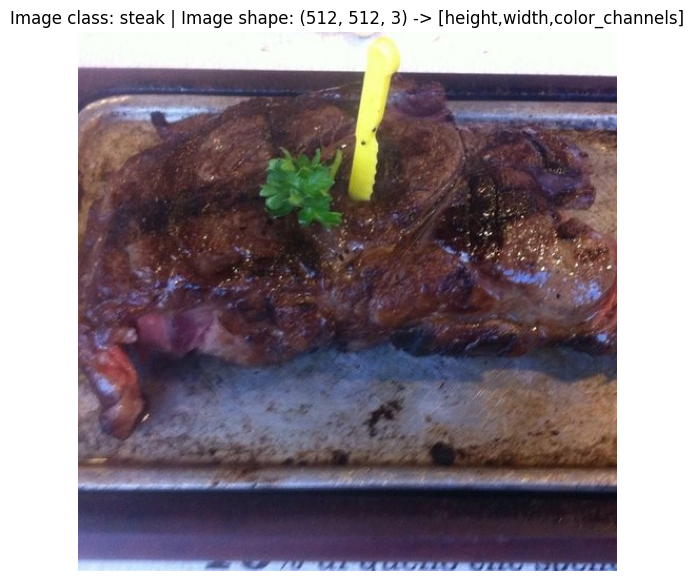

In [9]:
#plotting a image like before with matplotlib
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into an array
img_as_array=np.asarray(image)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color_channels]")
plt.axis(False)

In [10]:
#Turning images into tensors
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [11]:
#write a transform for image
data_transform=transforms.Compose([
    #resize the image to 64X64
    transforms.Resize(size=(64,64)),
    #Flip the images
    transforms.RandomHorizontalFlip(p=0.5),
    #turn image into torch tensor
    transforms.ToTensor()
])

In [12]:
data_transform(image)

tensor([[[0.9804, 0.9804, 0.9804,  ..., 0.9804, 0.9765, 0.9765],
         [0.9804, 0.9804, 0.9804,  ..., 0.9804, 0.9804, 0.9804],
         [0.9804, 0.9804, 0.9804,  ..., 0.9804, 0.9804, 0.9765],
         ...,
         [0.2275, 0.2235, 0.2275,  ..., 0.4157, 0.4314, 0.4471],
         [0.2549, 0.2510, 0.2549,  ..., 0.5412, 0.5529, 0.5647],
         [0.3608, 0.3647, 0.3804,  ..., 0.7804, 0.8000, 0.7843]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9922, 0.9922],
         ...,
         [0.1451, 0.1451, 0.1490,  ..., 0.4000, 0.4118, 0.4157],
         [0.1922, 0.2000, 0.2039,  ..., 0.5608, 0.5725, 0.5804],
         [0.4078, 0.4078, 0.4196,  ..., 0.8627, 0.8745, 0.8627]],

        [[0.9765, 0.9765, 0.9765,  ..., 0.9765, 0.9725, 0.9725],
         [0.9765, 0.9765, 0.9765,  ..., 0.9765, 0.9765, 0.9765],
         [0.9765, 0.9765, 0.9765,  ..., 0.9765, 0.9804, 0.

In [13]:
def plot_transformed_images(image_paths,transform,n=3,seed=None):
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax=plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #transform and plot the image
      #pytorch default is [c,H,W] but matplotlib default is [H,W,C]
      transformed_image=transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")
      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

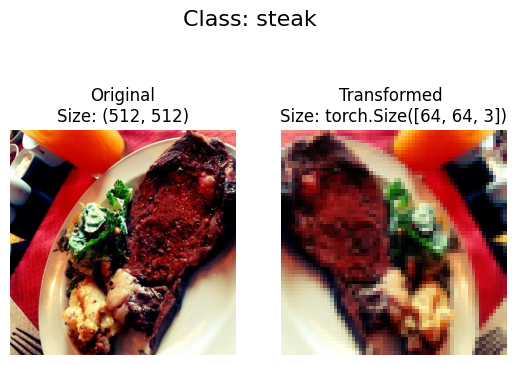

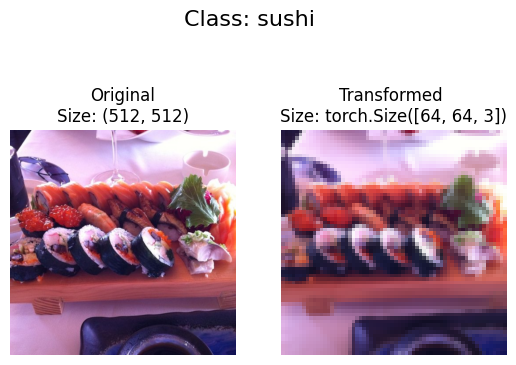

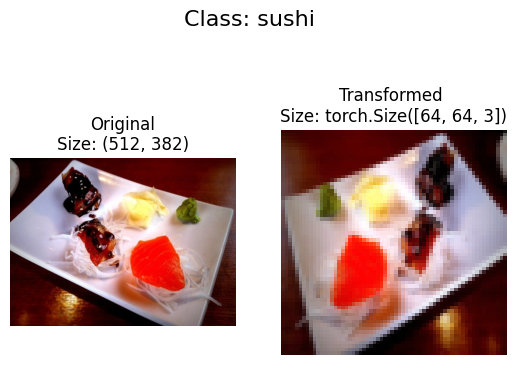

In [14]:
plot_transformed_images(image_path_list,data_transform,3)

In [15]:
#Load images using Imagefolder
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,transform=data_transform,target_transform=None)

In [16]:
print(train_data,test_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [17]:
#get class names as list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
len(train_data),len(test_data)

(225, 75)

In [20]:
#Index on traain data to get a single image and label
img,label=train_data[0][0],train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Image label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Text(0.5, 1.0, 'pizza')

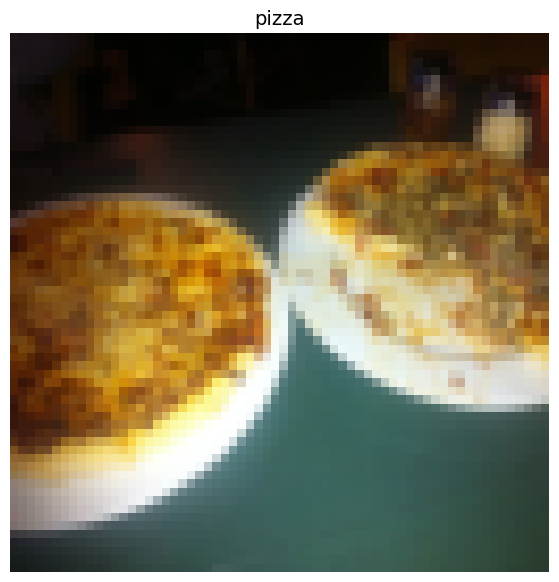

In [21]:
img_permute=img.permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

In [22]:
#Turn loaded images into dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,num_workers=os.cpu_count(),shuffle=False)

In [23]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ed82a2eb760>,
 <torch.utils.data.dataloader.DataLoader at 0x7ed82a2eb910>)

In [24]:
img,label=next(iter(train_dataloader))

In [25]:
print(f"Image shape: {img.shape}->[batch_size,color_channels,height,width]")
print(f"label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])->[batch_size,color_channels,height,width]
label shape: torch.Size([1])


In [26]:
#custom image data loading dataset
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [27]:
#creating a helper function to get classnames
target_directory=train_dir
print(f"Target_dir: {target_directory}")

class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target_dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory:str)->Tuple[List[str],Dict[str,int]]:
  classes=sorted(entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Could'nt find any classes in directory")
  class_to_idx={class_name:i for i,class_name in enumerate(classes)}
  return classes,class_to_idx


In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [30]:
#0.Create a custom dataset
from torch.utils.data import Dataset

#1.Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #2.Initialise our custom dataset
  def __init__(self,targ_dir:str,transform=None):
    #3.Create class attributes
    #get all of the image paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #setup transform
    self.transform=transform
    #create classes and class_to_idx
    self.classes,self.class_to_idx=find_classes(targ_dir)

  #4.Create a function to load images
  def load_image(self,index:int)->Image.Image:
    image_path=self.paths[index]
    return Image.open(image_path)

  #5.Overwrite the __len()__
  def __len__(self)->int:
    return len(self.paths)

  #6.Overwrite the __getitem()__ method to return a particular sample
  def __getitem__(self,index:int)->Tuple[torch.Tensor,int]:
    img=self.load_image(index)
    class_name=self.paths[index].parent.name
    class_idx=self.class_to_idx[class_name]

    #Transform if nescessary
    if self.transform:
      return self.transform(img),class_idx
    else:
      return img,class_idx


In [31]:
#create a transform
train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [32]:
#test out ImageFolderCustom
train_data_custom=ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)
test_data_custom=ImageFolderCustom(targ_dir=test_dir,transform=test_transforms)

In [33]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7ed82a2ebdf0>,
 <__main__.ImageFolderCustom at 0x7ed82a2eba00>)

In [34]:
len(train_data),len(train_data_custom)

(225, 225)

In [35]:
len(test_data),len(test_data_custom)

(75, 75)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
#create a helper function to display random images
#1.Create in a function to take a dataset
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n:int=10,
                          display_shape:bool=True,
                          seed:int=None):
  #2.Adjust display if n is too high
  if n>10:
    n=10
    display_shape=False
    print("For display purposes n should'nt be larger than 10.Setting n to 10 and removing shape display")

  #3.Set the random seed for reproducibility
  if seed:
    random.seed(seed)

  #4.Get random sample indexes
  random_samples_idx=random.sample(range(len(dataset)),k=n)

  #5.setup plot
  plt.figure(figsize=(16,8))
  #6.Loop through random indexes and plot them with matplotlib
  for i,targ_sample in enumerate(random_samples_idx):
    targ_image,targ_label=dataset[targ_sample][0],dataset[targ_sample][1]

    #7.Adjust tensor dimensions for plotting
    targ_image_adjust=targ_image.permute(1,2,0)

    #plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title=f"Class: {classes[targ_label]}"
      if display_shape:
        title=title+f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

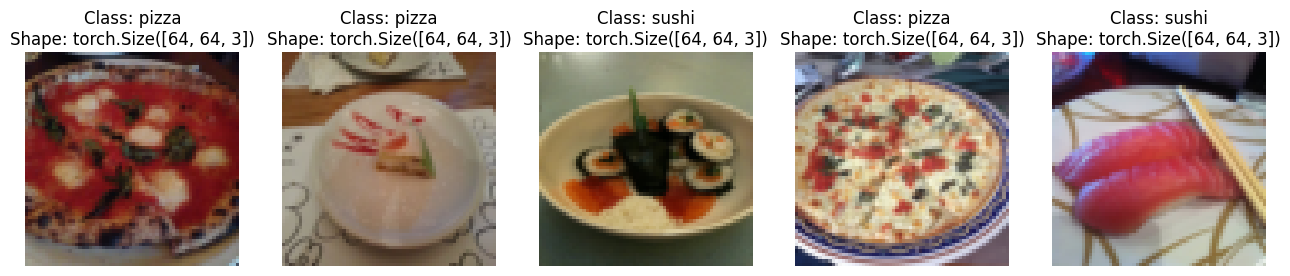

In [39]:
display_random_images(train_data,n=5,classes=class_names,seed=None)

For display purposes n should'nt be larger than 10.Setting n to 10 and removing shape display


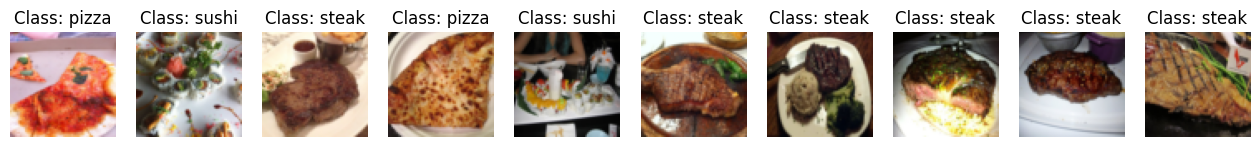

In [40]:
display_random_images(train_data_custom,n=20,classes=class_names,seed=None)

In [41]:
#Turn custom loaded images into dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
train_dataloader_custom=DataLoader(dataset=train_data_custom,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True)
test_dataloader_custom=DataLoader(dataset=test_data_custom,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False)

In [42]:
train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ed82a153430>,
 <torch.utils.data.dataloader.DataLoader at 0x7ed8296b0b80>)

In [43]:
#Get image and label from custom dataloader
img_custom,label_custom=next(iter(train_dataloader_custom))
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [44]:
#Other forms of transforms

In [45]:
#trivial Augment

In [46]:
from torchvision import transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [47]:
#Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/2603058.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/165639.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/482022.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/461689.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/922752.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/421476.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1382427.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3074367.jpg')]

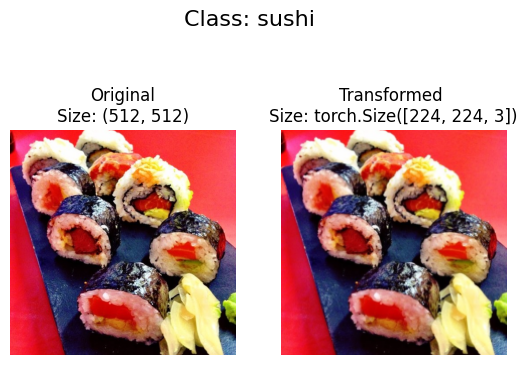

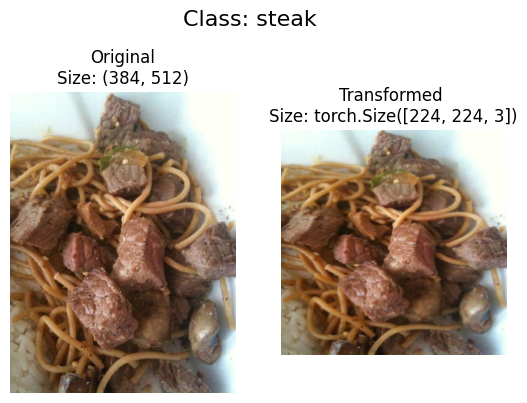

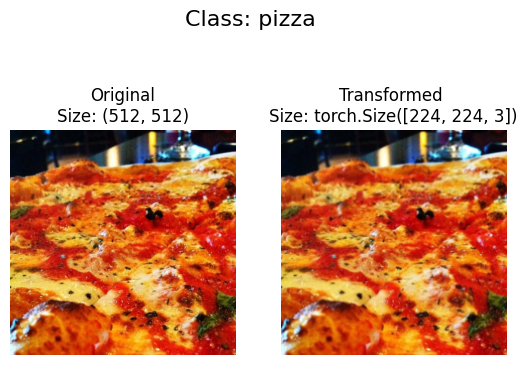

In [48]:
#plot random images
plot_transformed_images(image_paths=image_path_list,transform=train_transform,n=3,seed=None)

In [49]:
#Model 0:Tiny VGG without data augmentation

In [50]:
#create a simple transform
simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [51]:
from torchvision import datasets
train_data_simple=datasets.ImageFolder(root=train_dir,transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir,transform=simple_transform)

import os
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader_simple=DataLoader(dataset=train_data_simple,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True)
test_dataloader_simple=DataLoader(dataset=test_data_simple,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False)

In [52]:
#Create tinyVGG architecture
class tinyVGG(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int)->None:
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,out_features=output_shape)
    )
  def forward(self,x):
      x=self.conv_block_1(x)
      #print(x.shape)
      x=self.conv_block_2(x)
      #print(x.shape)
      x=self.classifier(x)
      #print(x.shape)
      return x
      #return self.classifer(self.conv_block_2(self.conv_block_1(x)))

In [53]:
torch.manual_seed(42)
model_0=tinyVGG(input_shape=3,hidden_units=10,output_shape=len(class_names))
model_0

tinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [54]:
#try forward pass on a single image
image_batch,label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [55]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [56]:
#torchinfo for getting summary of our model
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
tinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [57]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss,train_acc=0,0

  for batch, (X, y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)

    y_pred=model(X)

    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)
  return train_loss,train_acc

In [58]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:device):
  model.eval()

  test_loss,test_acc=0,0

  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)
      test_pred_logits=model(X)

      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()

      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=((test_pred_labels==y).sum().item()/len(test_pred_labels))

    test_loss=test_loss/len(dataloader)
    test_acc=test_acc/len(dataloader)
    return test_loss,test_acc

In [59]:
#create a train() function
from tqdm.auto import tqdm
#1.Create a train_function that takes in parameters+optimizer+loss_fn+dataloader
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module=nn.CrossEntropyLoss(),
          epochs:int=5,
          device=device):
  #2.create empty results dictionary
  results={"train_loss":[],"train_acc":[],"test_loss":[],"test_acc":[]}

  #3.loop through training and testing steps for number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=device)
    test_loss,test_acc=test_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,device=device)

    #4.Print what's hapenning
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} |Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    #5.Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  #6.return filled results at end of epochs
  return results

In [60]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS=5

#recreate a instance of TinyVGG
model_0=tinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_data.classes)).to(device)

#setup loss function
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),lr=0.001)

#Start the timer
from timeit import default_timer as timer
start_time=timer()

model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)
end_time=timer()
print(f"Total trianing time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1063 |Train Acc: 0.3047 | Test Loss: 1.0956 | Test Acc: 0.5703
Epoch: 1 | Train Loss: 1.0835 |Train Acc: 0.4453 | Test Loss: 1.0808 | Test Acc: 0.4023
Epoch: 2 | Train Loss: 1.1063 |Train Acc: 0.2812 | Test Loss: 1.0694 | Test Acc: 0.4023
Epoch: 3 | Train Loss: 1.0754 |Train Acc: 0.4766 | Test Loss: 1.0543 | Test Acc: 0.5234
Epoch: 4 | Train Loss: 1.0663 |Train Acc: 0.4023 | Test Loss: 1.0394 | Test Acc: 0.4023
Total trianing time: 16.728 seconds


In [61]:
#plot the loss curves
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [62]:
def plot_loss_curves(results:Dict[str,List[float]]):
  loss=results["train_loss"]
  test_loss=results["test_loss"]

  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  epochs=range(len(results["train_loss"]))

  #setup plot
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()


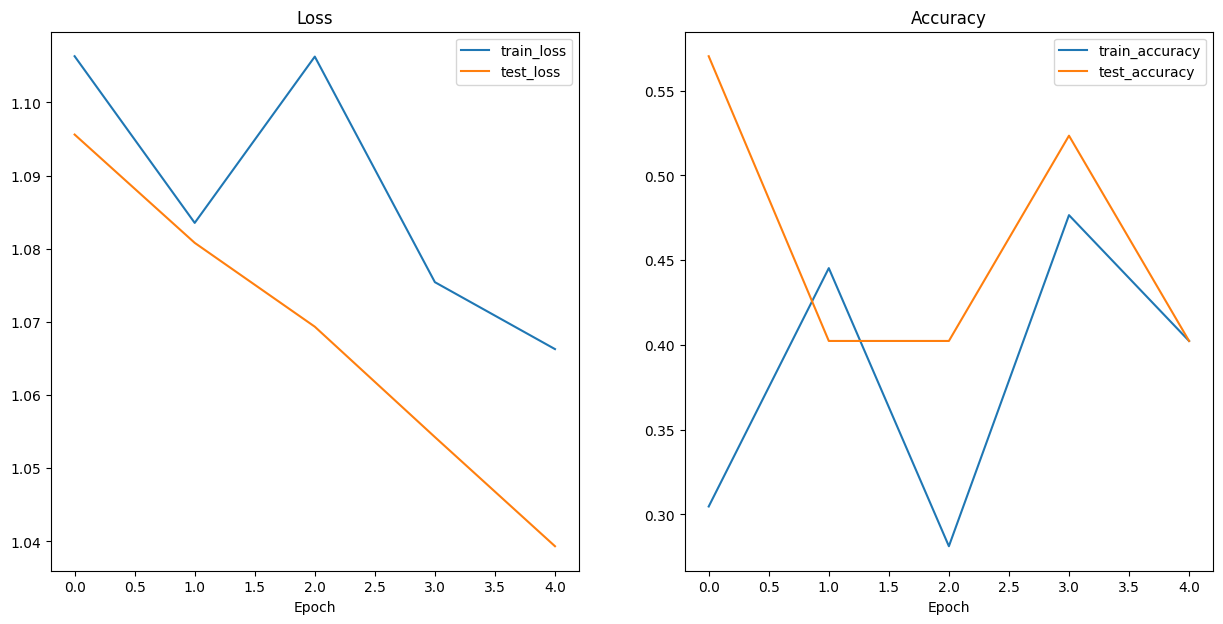

In [63]:
plot_loss_curves(model_0_results)

In [64]:
#Model 1:TinyVGG with data augmentation

In [65]:
#create transform with data augmentation
from torchvision import transforms
train_transform_trivial=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform_simple=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [66]:
#create data and dataset with data augmentation
from torchvision import datasets
train_data_augmented=datasets.ImageFolder(root=train_dir,transform=train_transform_trivial)
test_data_simple=datasets.ImageFolder(root=test_dir,transform=test_transform)

In [67]:
#turn datasets into dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
torch.manual_seed(42)
train_dataloader_augmented=DataLoader(train_data_augmented,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)
test_dataloader_simple=DataLoader(test_data_simple,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)

In [68]:
#Construct model 1
torch.manual_seed(42)
model_1=tinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_data_augmented.classes)).to(device)
model_1

tinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [69]:
#set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
NUM_EPOCHS=5

#Setup loss function
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),lr=0.001)

#start timer
from timeit import default_timer as timer
start_time=timer()
model_1_results=train(model=model_1,train_dataloader=train_dataloader_augmented,test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,loss_fn=loss_fn,epochs=NUM_EPOCHS,device=device)
end_time=timer()
print(f"Total trianing time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1049 |Train Acc: 0.2500 | Test Loss: 1.0937 | Test Acc: 0.4258
Epoch: 1 | Train Loss: 1.0792 |Train Acc: 0.4258 | Test Loss: 1.0762 | Test Acc: 0.4258
Epoch: 2 | Train Loss: 1.1276 |Train Acc: 0.3047 | Test Loss: 1.1214 | Test Acc: 0.3047
Epoch: 3 | Train Loss: 1.0823 |Train Acc: 0.4258 | Test Loss: 1.1012 | Test Acc: 0.3047
Epoch: 4 | Train Loss: 1.1020 |Train Acc: 0.3047 | Test Loss: 1.0911 | Test Acc: 0.3047
Total trianing time: 21.440 seconds


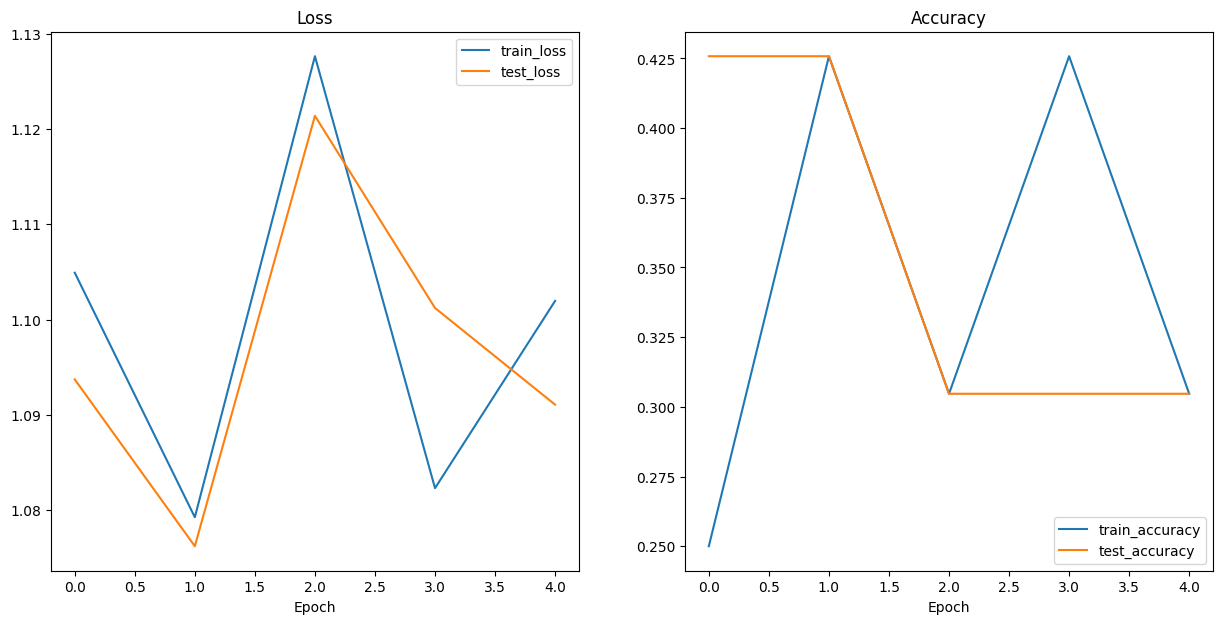

In [70]:
plot_loss_curves(model_1_results)

In [71]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.095614,0.570312
1,1.083541,0.445312,1.080813,0.402344
2,1.106267,0.281250,1.069354,0.402344
3,1.075440,0.476562,1.054270,0.523438
4,1.066293,0.402344,1.039351,0.402344


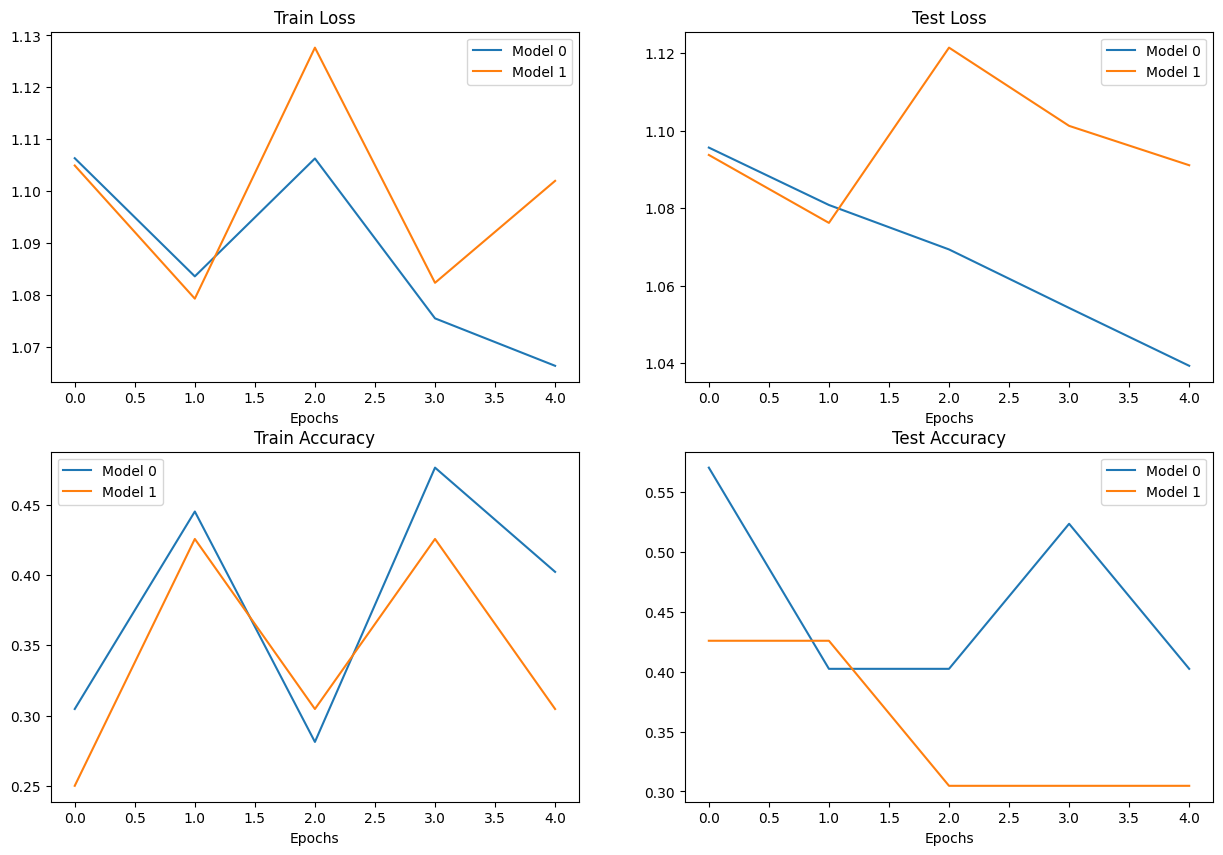

In [72]:
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [73]:
import requests
custom_image_path=data_path/"04-pizza-dad.jpeg"
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already path exists,skipping download")

In [74]:
#loading custom image with pytorch
import torchvision

custom_image_uint8=torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape:\n {custom_image_uint8.shape}")
print(f"Custom image dtype:\n {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape:
 torch.Size([3, 4032, 3024])
Custom image dty

(-0.5, 3023.5, 4031.5, -0.5)

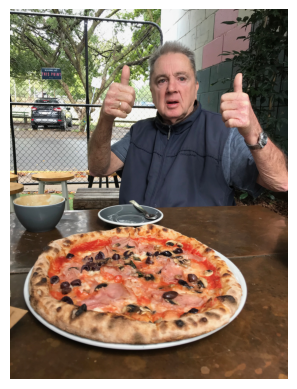

In [75]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis("off")

In [76]:
custom_image_uint8=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.
custom_image_uint8

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [77]:
#create transform pipeline to transform shape
custom_image_transform=transforms.Compose([transforms.Resize(size=(64,64))])
#transform target image
custom_image_transformed=custom_image_transform(custom_image_uint8)
custom_image_transformed.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 64, 64])

In [78]:
#Making prediction on custom image with pytorch model
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
custom_image_pred

tensor([[ 0.0846, -0.0769, -0.1243]])

In [79]:
custom_image_pred_probs=torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs

tensor([[0.3756, 0.3196, 0.3048]])

In [80]:
custom_image_pred_labels=torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_labels

tensor([0])

In [81]:
class_names[custom_image_pred_labels]

'pizza'

In [101]:
#putting custom image prediction together
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str]=None,
                        transform=None,
                        device=device):
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image=target_image/255.

  if transform:
    target_image=transform(target_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image=target_image.unsqueeze(0)

    target_image_pred=model(target_image.to(device))

  target_image_pred_probs=torch.softmax(target_image_pred,dim=1)

  target_image_pred_label=torch.argmax(target_image_pred_probs,dim=1)

  #plot the image alongside prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title=f"Pred:{class_names[target_image_pred_label.cpu()]} |Prob:{target_image_pred_probs.max().cpu():.3f}"
  else:
    title=f"Pred:{target_image_pred_label} |Prob:{target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis("off")

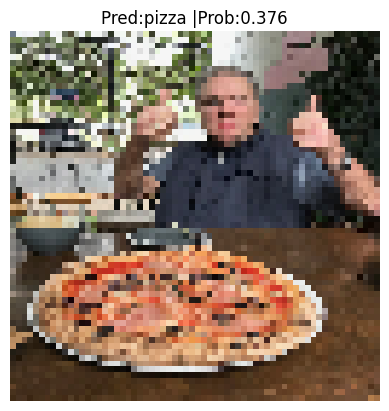

In [102]:
pred_and_plot_image(model=model_1,image_path=custom_image_path,class_names=class_names,transform=custom_image_transform)